
# Gaussian Belief Propagation applied to denoising a 1d line


This example is based on the [PyTorch colab by Joseph Ortiz](https://colab.research.google.com/drive/1-nrE95X4UC9FBLR0-cTnsIP_XhA_PZKW?usp=sharing)




In [1]:
!git clone https://github.com/probml/ggm-jax.git


Cloning into 'ggm-jax'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 30 (delta 8), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [2]:
!ls

ggm-jax  sample_data


In [3]:
%cd ggm-jax/belief-propagation


/content/ggm-jax/belief-propagation


In [4]:

import numpy as np
import os
import matplotlib.pyplot as plt

from typing import List, Callable, Optional, Union

import jax.numpy as jnp
from jax import random as jrand
from jax import config

from factor_graph import FactorGraph, GBPSettings
from gaussian import MeasModel, SquaredLoss

# Uncomment below expression to enforce CPU runtime
# config.update('jax_platform_name', 'cpu')



## Create Custom factors

In [5]:
def height_meas_fn(x: jnp.array, gamma: jnp.array):
    gamma = gamma.squeeze()
    J = jnp.array([1-gamma, gamma])
    return J @ x.reshape(-1,1)

def height_jac_fn(x: jnp.array, gamma: jnp.array):
    gamma = gamma.squeeze()
    return jnp.array([[1-gamma, gamma]])

class HeightMeasurementModel(MeasModel):
    def __init__(self, loss: SquaredLoss, gamma: jnp.array) -> None:
        MeasModel.__init__(self, height_meas_fn, height_jac_fn, loss, gamma)
        self.linear = True

def smooth_meas_fn(x: jnp.array):
    return jnp.array([x[1] - x[0]])

def smooth_jac_fn(x: jnp.array):
    return jnp.array([[-1., 1.]])

class SmoothingModel(MeasModel):
    def __init__(self, loss: SquaredLoss) -> None:
        MeasModel.__init__(self, smooth_meas_fn, smooth_jac_fn, loss)
        self.linear = True

## Set parameters

In [6]:
n_varnodes = 20
x_range = 10
n_measurements = 15

gbp_settings = GBPSettings(
    damping = 0.1,
    beta = 0.01,
    num_undamped_iters = 1,
    min_linear_iters = 1,
    dropout = 0.0,
)

## Gaussian noise measurement model parameters:

In [7]:
prior_cov = jnp.array([10.])
data_cov = jnp.array([0.05]) 
smooth_cov = jnp.array([0.1])
data_std = jnp.sqrt(data_cov)

## Create measurements 

In [8]:
key = jrand.PRNGKey(42)
meas_x = jrand.randint(key, [n_measurements], 0, x_range)
key, subkey = jrand.split(key)
meas_y = jnp.sin(meas_x) + jrand.normal(key, [n_measurements])*data_std

## Plot measurements

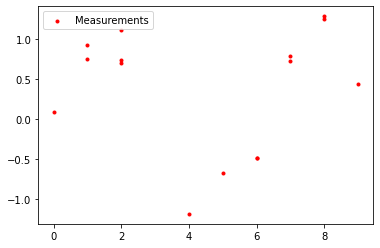

In [13]:
plt.scatter(meas_x, meas_y, color="red", label="Measurements", marker=".")
plt.legend()
plt.savefig('gbp-1d-data.pdf')
plt.show()

## Create factor graph 

In [14]:
fg = FactorGraph(gbp_settings)

xs = jnp.linspace(0, x_range, n_varnodes).reshape(-1,1)

for i in range(n_varnodes):
    fg.add_var_node(1, jnp.array([0.]), prior_cov)

for i in range(n_varnodes-1):
    fg.add_factor(
    [i, i+1], 
    jnp.array([0.]), 
    SmoothingModel(SquaredLoss(1, smooth_cov))
    )

for i in range(n_measurements):
    ix2 = np.argmax(xs > meas_x[i])
    ix1 = ix2 - 1
    gamma = (meas_x[i] - xs[ix1]) / (xs[ix2] - xs[ix1])
    fg.add_factor(
    [ix1, ix2], 
    meas_y[i], 
    HeightMeasurementModel(
        SquaredLoss(1, data_cov), 
        gamma  
        )
    )
fg.print(brief=True)


Factor Graph:
# Variable nodes: 20
# Factors: 34





## Plot initial beliefs and measurements

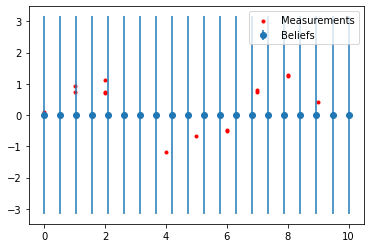

In [15]:
covs = jnp.sqrt(jnp.concatenate(fg.belief_covs()).flatten())
plt.errorbar(xs, fg.belief_means(), yerr=covs, fmt='o', color="C0", label='Beliefs')
plt.scatter(meas_x, meas_y, color="red", label="Measurements", marker=".")
plt.legend()
plt.show()

## Compute posterior beliefs with GBP 

In [16]:
fg.gbp_solve(n_iters=10)


Initial Energy 106.23512
Iter 1  --- Energy 45.52082 --- 
Iter 2  --- Energy 26.09324 --- 
Iter 3  --- Energy 27.78959 --- 
Iter 4  --- Energy 17.66786 --- 
Iter 5  --- Energy 16.32376 --- 
Iter 6  --- Energy 15.39065 --- 
Iter 7  --- Energy 14.81990 --- 
Iter 8  --- Energy 14.48639 --- 
Iter 9  --- Energy 14.44526 --- 
Iter 10  --- Energy 14.43492 --- 


## Plot beliefs and measurements

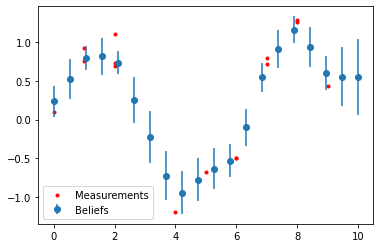

In [17]:
covs = jnp.sqrt(jnp.concatenate(fg.belief_covs()).flatten())
plt.errorbar(xs, fg.belief_means(), yerr=covs, fmt='o', color="C0", label='Beliefs')
plt.scatter(meas_x, meas_y, color="red", label="Measurements", marker=".")
plt.legend()
plt.savefig('gbp-1d-posteriors.pdf')
plt.show()